In [99]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from proj1_helpers import *
from implementations import *
from plots import *
from utils import *
from validation import *
import seaborn as sns
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [2]:
import datetime
DATA_TRAIN_PATH = 'data/train.csv' # TODO: download train data and supply path here

labels, input_data, ids = load_csv_data(DATA_TRAIN_PATH)

In [3]:
# standardize the data : 
x, mean_x, std_x = standardize(input_data)
y, tx = build_model_data(x, labels)

In [4]:
print(f'shape y : {y.shape}, shape x : {tx.shape}')

shape y : (250000,), shape x : (250000, 31)


## Do your thing crazy machine learning thing here :) ...

In [5]:
# #visualize th distribution of the features
# l=[]
# for col_name in df_data.columns: 
#     l.append(col_name)
    
    
# fig, axes = plt.subplots(5, 3, figsize=(20, 20))
# fig.suptitle(
#     "Boxplot distribution of different features of the data"
# )
# sns.boxplot(
#     data=df_data[[l[2], l[3]]], ax=axes[0][0], orient="v"
# )
# sns.boxplot(
#     data=df_data[[l[4], l[5]]], ax=axes[0][1], orient="v"
# )
# sns.boxplot(
#     data=df_data[[l[6], l[7]]], ax=axes[0][2], orient="v"
# )
# sns.boxplot(
#     data=df_data[[l[8], l[9]]], ax=axes[1][0], orient="v"
# )
# sns.boxplot(
#     data=df_data[[l[10], l[11]]], ax=axes[1][1], orient="v"
# )
# sns.boxplot(
#     data=df_data[[l[12], l[13]]], ax=axes[1][2], orient="v"
# )
# sns.boxplot(
#     data=df_data[[l[14], l[15]]], ax=axes[2][0], orient="v"
# )
# sns.boxplot(
#     data=df_data[[l[16], l[17]]], ax=axes[2][1], orient="v"
# )
# sns.boxplot(
#     data=df_data[[l[18], l[19]]], ax=axes[2][2], orient="v"
# )
# sns.boxplot(
#     data=df_data[[l[20], l[21]]], ax=axes[3][0], orient="v"
# )
# sns.boxplot(
#     data=df_data[[l[22], l[23]]], ax=axes[3][1], orient="v"
# )
# sns.boxplot(
#     data=df_data[[l[24], l[25]]], ax=axes[3][2], orient="v"
# )
# sns.boxplot(
#     data=df_data[[l[26], l[27]]], ax=axes[4][0], orient="v"
# )
# sns.boxplot(
#     data=df_data[[l[28], l[29]]], ax=axes[4][1], orient="v"
# )
# sns.boxplot(
#     data=df_data[[l[30], l[31]]], ax=axes[4][2], orient="v"
# )
# ;

In [6]:
# splitting data for the training and validation
seed = 46
ratio = 0.8
x_train, y_train, x_test, y_test = split_data(tx, y, ratio=ratio, seed=seed)

## Least Squares GD

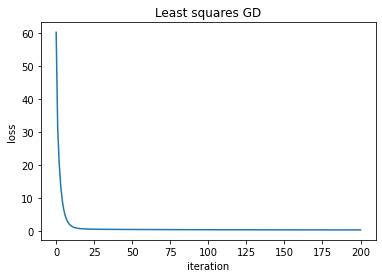

Train loss is 0.4287
Test loss is 0.4270


In [44]:
max_iters = 200
gamma = 0.05
initial_w = np.ones((x_train.shape[1]))

plt.title('Least squares GD')
w, loss = least_squares_GD(y_train, x_train, initial_w, max_iters, gamma, plot_loss = True)
test_loss = compute_mse(y_test, x_test, w)
print("Train loss is {:.4f}".format(loss))
print("Test loss is {:.4f}".format(test_loss))

### Cross validation for least squares GD

100%|██████████| 2/2 [04:53<00:00, 146.92s/it]

Accuracy is 0.6951


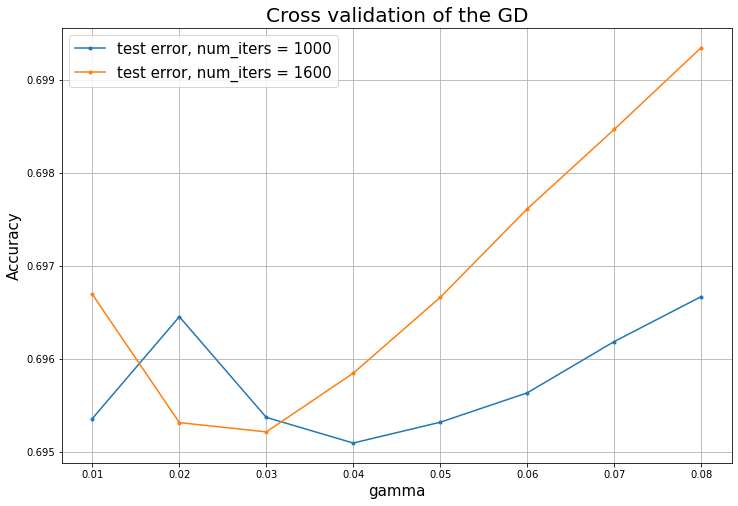

In [30]:
# parameters setting
type_ = 'GD'
bd_left = -2
bd_right = -2
# grid for hyperparameters
gammas = np.linspace(10**bd_left, 8*10**bd_right, 8)
max_iters = np.arange(1000, 2200, 600)
cross_validation_demo(type_=type_, y=y, tx=tx, bd_left=bd_left, bd_right=bd_right, gammas=gammas, max_iters=max_iters, seed=seed)

**Gradient decent converges if gamma < 0.09. Also we decided not to increase max_iter parameter up to 2000 due to the duration of the computations.  
In this setting the best gamma = 0.08 and the best max_iter = 2000.  
Best test loss = 0.3708**

## Least Squares SGD

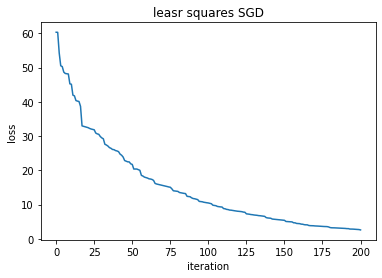

Train loss is 2.58
Test loss is 2.58


In [36]:
max_iters = 200
gamma = 0.08 #w
initial_w = np.ones((x_train.shape[1]))

plt.title('leasr squares SGD')
w, loss = least_squares_SGD(y_train, x_train, initial_w, max_iters, gamma, plot_loss = True)
test_loss = compute_mse(y_test, x_test, w)
print("Train loss is {:.2f}".format(loss))
print("Test loss is {:.2f}".format(test_loss))

### Cross validation for least squares SGD

100%|██████████| 6/6 [00:53<00:00,  8.90s/it]

Train loss is 4.6506
Test loss is 4.6449


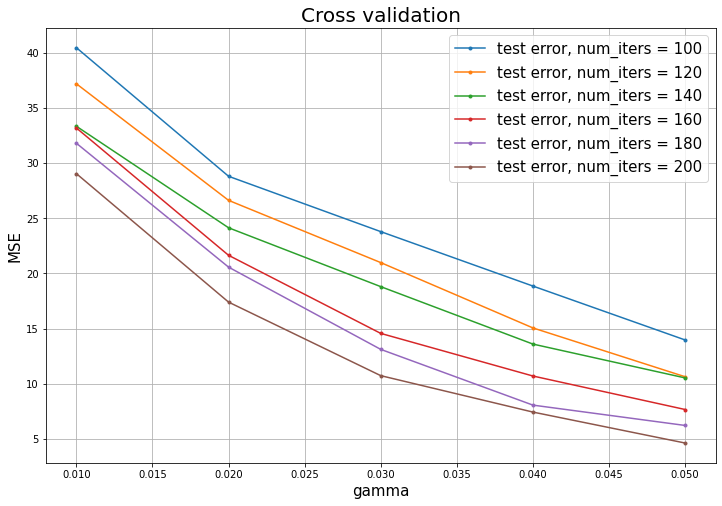

In [8]:
# parameters setting
type_ ='SGD'
bd_left = -2
bd_right = -2
# grid for hyperparameters
gammas = np.linspace(10**bd_left, 5*10**bd_right, 5)
max_iters = np.arange(100, 220, 20)
cross_validation_demo(type_=type_, y=y, tx=tx, bd_left=bd_left, bd_right=bd_right, gammas=gammas, max_iters=max_iters, seed=seed)

## Least Squares

In [48]:
w, loss = least_squares(y, tx)
test_loss = compute_mse(y_test, x_test, w)
print("Train loss is {:.4f}".format(loss))
print("Test loss is {:.4f}".format(test_loss))

Train loss is 0.3394
Test loss is 0.3373


## Ridge regression

In [54]:
w, loss = ridge_regression(y, tx, lambda_=1e-4)
test_loss = compute_mse(y_test, x_test, w)
print("Train loss is {:.4f}".format(loss))
print("Test loss is {:.4f}".format(test_loss))

Train loss is 0.3395
Test loss is 0.3373


100%|██████████| 3/3 [03:37<00:00, 72.57s/it]


Train loss is 0.3245
Test loss is 0.3395


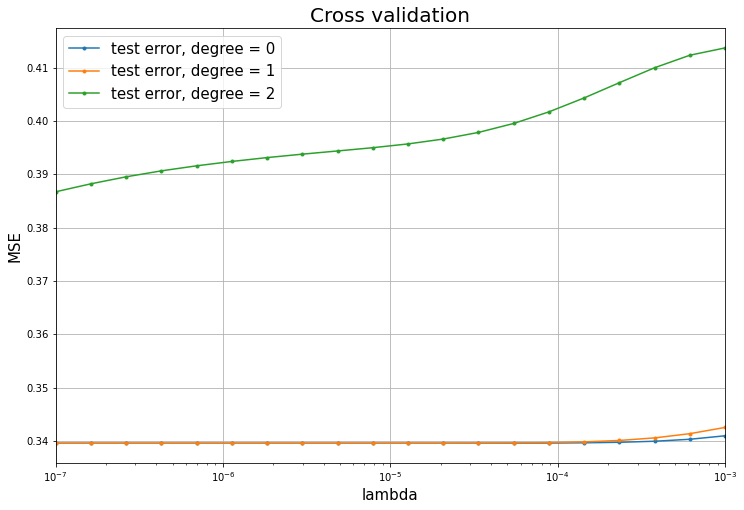

In [96]:
# parameters setting
type_ = 'RR'
bd_left = -5
bd_right = -2
# grid for hyperparameters
lambdas = np.logspace(bd_left, bd_right, 20)
degrees = np.arange(3)
cross_validation_demo(type_=type_, y=y, tx=tx, bd_left=bd_left, bd_right=bd_right, lambdas=lambdas, degrees=degrees, seed=seed)

**The oplimal degree is 0, which means that it's better not to apply polynomical transformation to the basis, let's find best lambda for degree = 0**

100%|██████████| 1/1 [00:06<00:00,  6.05s/it]


Train loss is 0.3394
Test loss is 0.3395


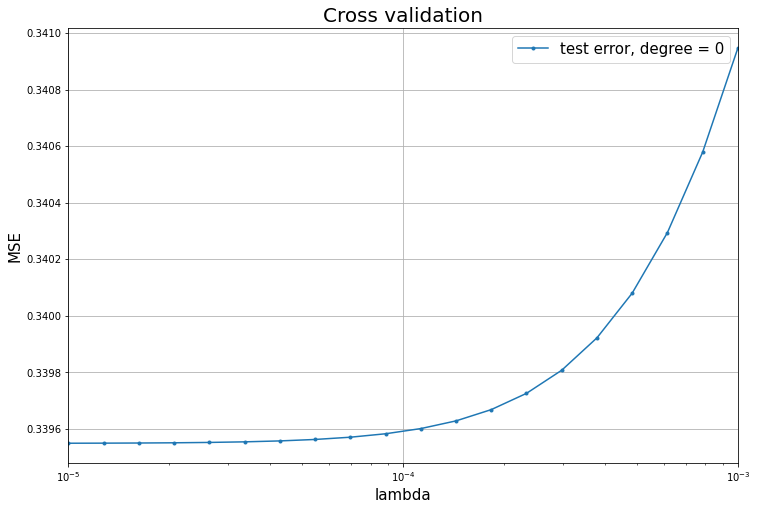

In [99]:
# parameters setting
type_ = 'RR'
bd_left = -5
bd_right = -3
# grid for hyperparameters
lambdas = np.logspace(bd_left, bd_right, 20)
degrees = np.arange(1)
cross_validation_demo(type_=type_, y=y, tx=tx, bd_left=bd_left, bd_right=bd_right, lambdas=lambdas, degrees=degrees, seed=seed)

**Optimal lambda is equal 10^{-5}  
Test error: 0.3395**

10it [00:08,  1.13it/s]


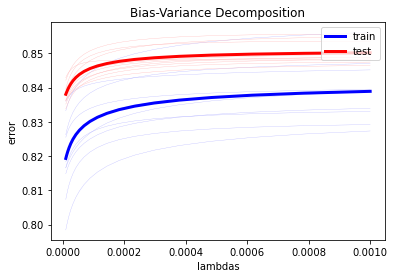

In [103]:
#bias/variance decomposition : 
def bias_variance_demo():
    """The entry."""
    # define parameters
    seeds = range(100)
    ratio_train = 0.005
    lambdas = np.logspace(-5, -3, 20)
    degree=0
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(lambdas)))
    rmse_te = np.empty((len(seeds), len(lambdas)))
    for index_seed, seed in tqdm(enumerate(seeds)):
        np.random.seed(seed)
        # split data with a specific seed
        x_train,y_train,x_test,y_test = split_data(tx, y, ratio_train, seed)
        if degree == 0:
            x_train_phi =  x_train
            x_test_phi  =  x_test
        else:
            x_train_phi =  build_poly(x_train,degree)
            x_test_phi  =  build_poly(x_test,degree)
        for index_degree,lambda_ in enumerate(lambdas) :
            w_tr,_ = ridge_regression(y_train,x_train_phi,lambda_)
            rmse_te[index_seed,index_degree] = np.sqrt(2*compute_mse(y_test,x_test_phi,w_tr))
            rmse_tr[index_seed,index_degree] = np.sqrt(2*compute_mse(y_train,x_train_phi,w_tr))
        # bias_variance_decomposition
    bias_variance_decomposition_visualization(lambdas, rmse_tr, rmse_te)

bias_variance_demo()

## Logistic Regression

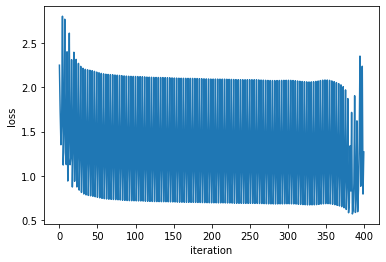

Train loss is 1.27
Test loss is 3.21


In [108]:
max_iters = 400
gamma = 1.0
initial_w = np.random.rand((x_train.shape[1]))

w, loss = logistic_regression(y_train, x_train, initial_w, max_iters, gamma, plot_loss = True)
test_loss = compute_mse(y_test, x_test, w)
print("Train loss is {:.2f}".format(loss))
print("Test loss is {:.2f}".format(test_loss))

### Cross validation for logistic regression

In [111]:
bd_left = -4
bd_right = -1
np.linspace(10**bd_left, 10**bd_right, 10)

array([0.0001, 0.0112, 0.0223, 0.0334, 0.0445, 0.0556, 0.0667, 0.0778,
       0.0889, 0.1   ])

100%|██████████| 6/6 [02:19<00:00, 23.30s/it]


Accuracy is 0.5192


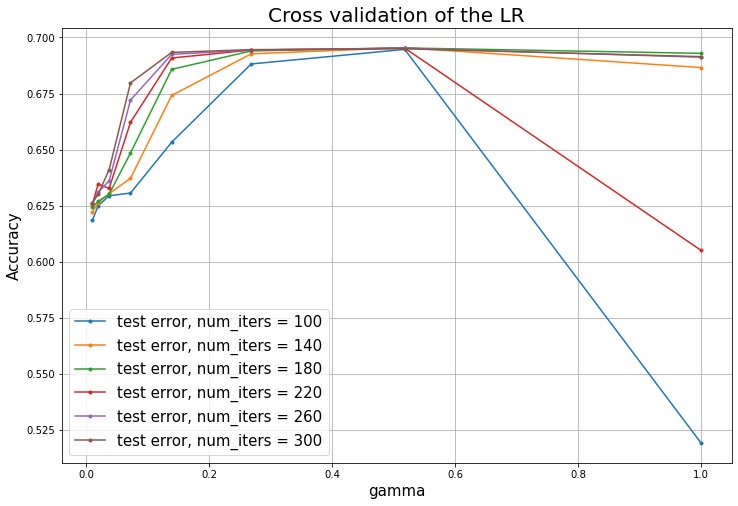

In [95]:
# parameters setting
type_ = 'LR'
bd_left = -2
bd_right = 0
# grid for hyperparameters
# gammas = np.linspace(10**bd_left, 10**bd_right, 10)
gammas = np.logspace(bd_left, bd_right, 8)
max_iters = np.arange(100, 320, 40)
cross_validation_demo(type_=type_, y=y, tx=tx, bd_left=bd_left, bd_right=bd_right, gammas=gammas, max_iters=max_iters, seed=seed)

100%|██████████| 9/9 [10:59<00:00, 73.29s/it] 


Accuracy is 0.7066


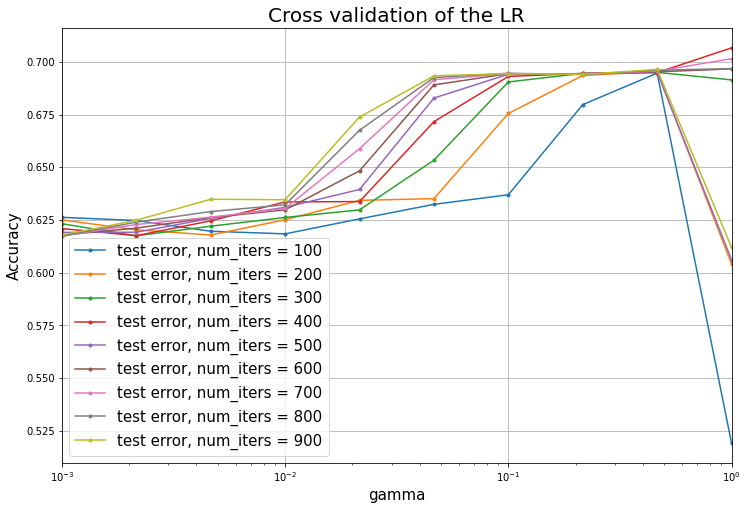

In [100]:
# parameters setting
type_ = 'LR'
bd_left = -3
bd_right = 0
# grid for hyperparameters
# gammas = np.linspace(10**bd_left, 10**bd_right, 10)
gammas = np.logspace(bd_left, bd_right, 10)
max_iters = np.arange(100, 1000, 100)
cross_validation_demo(type_=type_, y=y, tx=tx, bd_left=bd_left, bd_right=bd_right, gammas=gammas, max_iters=max_iters, seed=seed)

In [102]:
np.logspace(bd_left, bd_right, 10)

array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ])

## Logistic Regression with Regularization

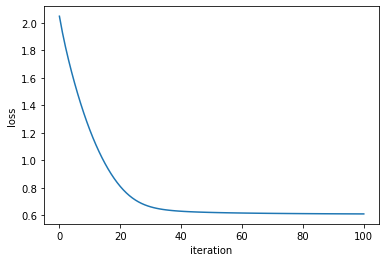

Train loss is 0.61
Test loss is 0.48


In [90]:
max_iters = 100
gamma = 0.46415888
initial_w = np.random.rand((x_train.shape[1]))
lambda_ = 1e-1

w_log, loss = reg_logistic_regression(y_train, x_train, lambda_, initial_w, max_iters, gamma, plot_loss = True)
test_loss = compute_mse(y_test, x_test, w_log)
print("Train loss is {:.2f}".format(loss))
print("Test loss is {:.2f}".format(test_loss))

### Cross validation for logistic regression with regularizarion

In [69]:
# parameters setting
type_ = 'RLR'
bd_left = -5
bd_right = 1
max_iters = 200
gammas = 0.1
# grid for hyperparameters
lambdas = np.logspace(bd_left, bd_right, 20)
degrees = np.arange(1)
cross_validation_demo(type_=type_, y=y, tx=tx, bd_left=bd_left, bd_right=bd_right, lambdas=lambdas, degrees=degrees, max_iters=max_iters, gammas=gammas, seed=seed)

# Look at the results : 


In [105]:
#split the data to validate the selected models 
ratio = 0.7
tx_tr, tx_te, y_tr, y_te = split_data(tx, y, ratio)

# 2 Accuracy of the selected models

In [109]:
#weights, loss = least_squares(y_tr, tx_tr)
y_pred = predict_labels_lr(w, x_test)
# print(w_log)
accu  = accuracy(y_pred,y_test)
print("accuracy:",accu)

accuracy: 0.52094


In [14]:
len(y_pred[y_pred == -1])

0

In [11]:
len(y_pred)

50000

In [37]:
y_test[0]

-1.0

# 4. Confusion matrix 

Text(51.0, 0.5, 'expected')

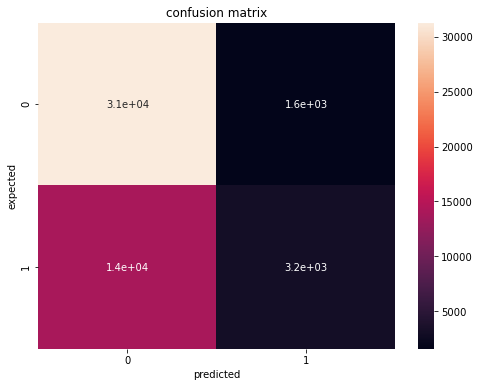

In [48]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
#confusion matrix
fig, ax = plt.subplots(figsize = (8, 6))
cm = confusion_matrix(y_test, y_pred, labels = [-1.0, 1.0])
sn.heatmap(cm, annot = True, axes = ax)
plt.title("confusion matrix")
plt.xlabel("predicted")
plt.ylabel("expected")


# 5. Improvements : PCA


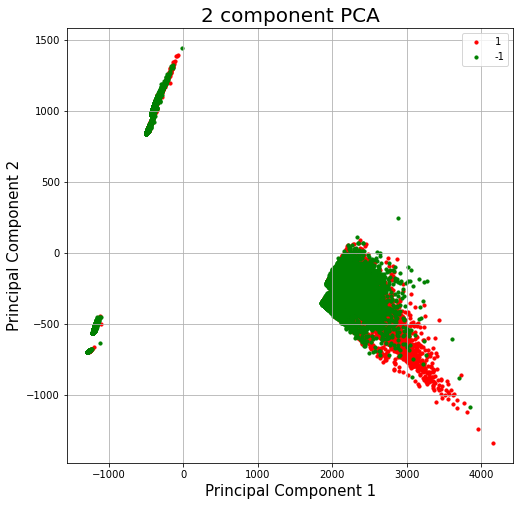

In [70]:
#PCA 2D  : 
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(input_data)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
df_target=pd.DataFrame(y,columns=['target'])
finalDf = pd.concat([principalDf, df_target], axis = 1)
df_target.head()

fig= plt.figure(figsize = (8,8))

ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
#ax.set_zlabel('Principal Component 3', rotation=90)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1, -1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               #, finalDf.loc[indicesToKeep, 'principal component 3']
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()

<Figure size 480x480 with 0 Axes>

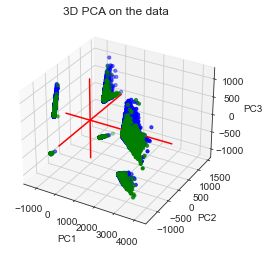

In [83]:
#PCA 3D :
# Get the iris dataset
sns.set_style("white")

# create figure
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)
 
# Run The PCA
pca = PCA(n_components=3)

principalComponents = pca.fit_transform(input_data)
principalDf = pd.DataFrame(data = principalComponents
                           , columns = ['principal component 1', 'principal component 2','principal component 3'])
df_target=pd.DataFrame(y,columns=['target'])
finalDf = pd.concat([principalDf, df_target], axis = 1)
 
# Store results of PCA in a data frame
 
# Plot initialisation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

targets = [1, -1]
colors = ['g', 'b']

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , finalDf.loc[indicesToKeep, 'principal component 3']
               #, finalDf.loc[indicesToKeep, 'principal component 3']
               , c = color
               , s = 10)

 
# make simple, bare axis lines through space:
xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA on the data")
plt.show()

## Generate predictions and save ouput in csv format for submission:

In [50]:
DATA_TEST_PATH = 'data/test.csv'  # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [51]:
weights = w_log
weights = weights[1:31]
y_prediction = predict_labels_lr(weights, tX_test)
y_prediction.shape

(568238,)

In [52]:
OUTPUT_PATH = 'data/pred.csv' # TODO: fill in desired name of output file for submission
create_csv_submission(ids_test, y_prediction, OUTPUT_PATH)